In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(style="white")

from datetime import datetime

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import r2_score,mean_squared_error

import tensorflow as tf

In [2]:
df = pd.read_csv('dftRoadSafety_Accidents_2016.csv')
df

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2640\2633080375.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dftRoadSafety_Accidents_2016.csv')


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,0,0,5,1,1,0,0,1,1,E01000543
1,2016010000006,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,...,0,0,4,1,1,0,0,1,1,E01000375
2,2016010000008,505930.0,183850.0,-0.473837,51.543563,1,3,1,1,01/11/2016,...,0,0,4,1,1,0,0,1,1,E01033725
3,2016010000016,527770.0,168930.0,-0.164442,51.404958,1,3,1,1,01/11/2016,...,0,0,1,1,1,0,0,1,1,E01003379
4,2016010000018,510740.0,177230.0,-0.406580,51.483139,1,3,2,1,01/11/2016,...,0,0,1,1,1,0,0,1,1,E01002583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136616,2016984130916,319273.0,574564.0,-3.265390,55.058998,98,3,2,1,28/10/2016,...,0,0,4,1,2,0,0,2,1,NaN
136617,2016984131116,316143.0,568615.0,-3.312631,55.005033,98,3,2,2,01/11/2016,...,0,0,1,1,1,0,0,2,1,NaN
136618,2016984131216,322903.0,573365.0,-3.208249,55.048803,98,3,1,1,27/10/2016,...,0,0,6,1,2,0,0,2,1,NaN
136619,2016984131316,318673.0,566850.0,-3.272584,54.989597,98,3,1,3,29/10/2016,...,0,0,4,1,1,0,0,2,1,NaN


In [3]:
# Extract month from date
def month_from_date(date):
    dmyyyy = datetime.strptime(date, '%d/%m/%Y')
    return int(datetime.strftime(dmyyyy, '%m'))

df['Month_of_Year'] = df['Date'].apply(month_from_date)

In [4]:
# Extract hour from time
def hour_from_time(time):
    try:
        hhmm = datetime.strptime(time, '%H:%M')
        return int(datetime.strftime(hhmm, '%H'))
    except Exception:
        # Some times are nan
        return 0

df['Hour_of_Day'] = df['Time'].apply(hour_from_time)

In [5]:
# Drop columns which cannot be used as predictors of cycling accidents
df = df.drop(['Number_of_Vehicles', 'Local_Authority_(District)', 
                                    'Police_Force', 'Location_Easting_OSGR', 
                                    'Location_Northing_OSGR', 'Speed_limit',
                                    '1st_Road_Class', 'Road_Type', 'Date', 'Time', 
                                    'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 
                                    '2nd_Road_Number', 'Special_Conditions_at_Site', 
                                    'Carriageway_Hazards', 'Number_of_Casualties',
                                    'Pedestrian_Crossing-Physical_Facilities', 
                                    'Pedestrian_Crossing-Human_Control',
                                    'Did_Police_Officer_Attend_Scene_of_Accident', 
                                    'Local_Authority_(Highway)', 
                                    'LSOA_of_Accident_Location', 'Accident_Severity', 
                                    '1st_Road_Number'], axis=1)

In [6]:
# Remove rows where latitude or longitude is NaN
df = df[np.isfinite(df['Longitude'])]
df = df[np.isfinite(df['Latitude'])]

In [7]:
df.head()

,Accident_Index,Longitude,Latitude,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day
0,2016010000005,-0.279323,51.584754,3,5,1,1,1,11,2
1,2016010000006,0.184928,51.449595,3,4,1,1,1,11,0
2,2016010000008,-0.473837,51.543563,3,4,1,1,1,11,1
3,2016010000016,-0.164442,51.404958,3,1,1,1,1,11,9
4,2016010000018,-0.406580,51.483139,3,1,1,1,1,11,7


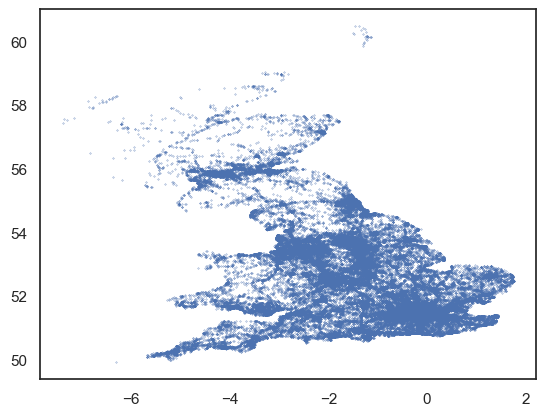

In [8]:
# Plot the accident coordinates
plt.plot(df.Longitude, df.Latitude, 'b.', ms=0.5)

In [9]:
print ("There are", len(df.index), "unique accidents")

There are 136614 unique accidents


In [10]:
# Read in the casualty data
cas_df = pd.read_csv('Cas.csv')
cas_df

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2016010000005,2,1,1,1,23,5,3,0,0,0,0,0,2,1,4
1,2016010000006,1,1,1,2,36,7,3,0,0,0,0,0,9,1,10
2,2016010000008,1,1,1,1,24,5,3,0,0,0,0,0,9,1,8
3,2016010000016,1,1,2,2,59,9,3,0,0,0,3,0,11,1,4
4,2016010000018,2,1,1,1,28,6,3,0,0,0,0,0,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181379,2016984131316,1,1,1,1,17,4,3,0,0,0,0,0,9,1,6
181380,2016984131316,1,2,2,1,17,4,3,0,0,1,0,0,9,-1,-1
181381,2016984131316,1,3,2,1,21,5,3,0,0,2,0,0,9,1,1
181382,2016984133416,1,1,1,1,48,8,3,0,0,0,0,0,9,1,-1


In [11]:
# Remove non-cycling casualties
cas_df = cas_df[cas_df.Casualty_Type==1]

In [12]:
# Drop columns which cannot be used as predictors of cycling accidents
cas_df = cas_df.drop(['Bus_or_Coach_Passenger', 'Car_Passenger', 
                                    'Pedestrian_Movement', 'Pedestrian_Location', 
                                    'Casualty_Reference', 'Vehicle_Reference', 
                                    'Casualty_Class', 'Age_of_Casualty',  
                                    'Casualty_Severity', 'Casualty_IMD_Decile', 
                                    'Pedestrian_Road_Maintenance_Worker'], axis=1)
cas_df.head()

,Accident_Index,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Type,Casualty_Home_Area_Type
4,2016010000018,1,6,1,1
17,2016010000046,1,4,1,1
29,2016010000058,1,5,1,1
35,2016010000069,1,6,1,1
36,2016010000072,1,5,1,1


In [13]:
print ("There are", len(cas_df.index), "cycling casualties")

There are 18477 cycling casualties


In [14]:
# Merge accident and casualty data for cycling accidents
final_df = pd.merge(df, cas_df, on='Accident_Index', how='left')

In [15]:
final_df = final_df.drop(['Accident_Index'], axis=1)

In [16]:
# Replace NaN with zero
final_df.fillna(0, inplace=True)

In [17]:
# Casualty data after merge is cast to float. Cast back to integer
final_df['Casualty_Type'] = final_df['Casualty_Type'].astype(int)

In [18]:
# We will use Casualty_Type as an indicator of a cycling accident. If 1 it is a cycling accident and if 0 a non-cycling accident
final_df = final_df.rename(columns={'Casualty_Type': 'Cycling_Accident'})

In [19]:
# Display our data
final_df

,Longitude,Latitude,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Cycling_Accident,Casualty_Home_Area_Type
0,-0.279323,51.584754,3,5,1,1,1,11,2,0.0,0.0,0,0.0
1,0.184928,51.449595,3,4,1,1,1,11,0,0.0,0.0,0,0.0
2,-0.473837,51.543563,3,4,1,1,1,11,1,0.0,0.0,0,0.0
3,-0.164442,51.404958,3,1,1,1,1,11,9,0.0,0.0,0,0.0
4,-0.406580,51.483139,3,1,1,1,1,11,7,1.0,6.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136822,-3.265390,55.058998,6,4,1,2,2,10,6,0.0,0.0,0,0.0
136823,-3.312631,55.005033,3,1,1,1,2,11,16,0.0,0.0,0,0.0
136824,-3.208249,55.048803,5,6,1,2,2,10,7,0.0,0.0,0,0.0
136825,-3.272584,54.989597,7,4,1,1,2,10,20,0.0,0.0,0,0.0


In [20]:
# Convert the latitude and longitude coordinates to area squares
latitude_min = min(final_df['Latitude'])
latitude_max = max(final_df['Latitude'])
longitude_min = min(final_df['Longitude'])
longitude_max = max(final_df['Longitude'])

In [21]:
# Determine the required step for a given number of areas
latitude_step = (latitude_max - latitude_min) / 1000
longitude_step = (longitude_max - longitude_min) / 1000

In [22]:
# Determine the latitude area
def calc_lat_area(current_lat):
    return int((current_lat - latitude_min) / latitude_step)

# Determine the longitude area
def calc_lon_area(current_lon):
    return int((current_lon - longitude_min) / longitude_step)

In [23]:
# Create new columns with the latitude and longitude areas
final_df["Latitude_Area"] = list(map(calc_lat_area, final_df["Latitude"]))
final_df["Longitude_Area"] = list(map(calc_lon_area, final_df["Longitude"]))

# Drop the old latitude and logitude columns
final_df = final_df.drop(['Longitude', 'Latitude'], axis=1)

In [24]:
final_df.head()

,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Cycling_Accident,Casualty_Home_Area_Type,Latitude_Area,Longitude_Area
0,3,5,1,1,1,11,2,0.0,0.0,0,0.0,157,777
1,3,4,1,1,1,11,0,0.0,0.0,0,0.0,144,828
2,3,4,1,1,1,11,1,0.0,0.0,0,0.0,153,756
3,3,1,1,1,1,11,9,0.0,0.0,0,0.0,140,789
4,3,1,1,1,1,11,7,1.0,6.0,1,1.0,147,763


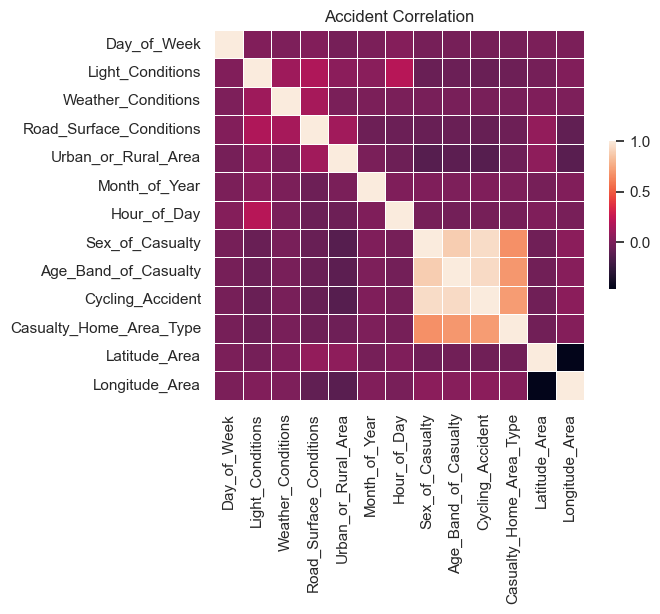

In [25]:
# Compute the correlation matrix
corr = final_df.corr()

# Draw the correlation matrix
sns.heatmap(corr, square=True, linewidths=.4, cbar_kws={"shrink": .4})

plt.title("Accident Correlation")
plt.show()

In [26]:
# Split the data, 75% for training and 25% for validation
x = final_df.drop(['Cycling_Accident'], axis=1)
y = final_df['Cycling_Accident']



In [27]:
x

,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Home_Area_Type,Latitude_Area,Longitude_Area
0,3,5,1,1,1,11,2,0.0,0.0,0.0,157,777
1,3,4,1,1,1,11,0,0.0,0.0,0.0,144,828
2,3,4,1,1,1,11,1,0.0,0.0,0.0,153,756
3,3,1,1,1,1,11,9,0.0,0.0,0.0,140,789
4,3,1,1,1,1,11,7,1.0,6.0,1.0,147,763
...,...,...,...,...,...,...,...,...,...,...,...,...
136822,6,4,1,2,2,10,6,0.0,0.0,0.0,486,450
136823,3,1,1,1,2,11,16,0.0,0.0,0.0,481,445
136824,5,6,1,2,2,10,7,0.0,0.0,0.0,485,457
136825,7,4,1,1,2,10,20,0.0,0.0,0.0,479,450


In [28]:
y

0         0
1         0
2         0
3         0
4         1
         ..
136822    0
136823    0
136824    0
136825    0
136826    0
Name: Cycling_Accident, Length: 136827, dtype: int32

In [29]:
(xtrain, xtest, ytrain, ytest) = train_test_split(x.values, 
                                                  y.values, 
                                                  test_size=0.25, 
                                                  random_state=42)

In [30]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
xtrain = minmax.fit_transform(xtrain)
xtest = minmax.transform(xtest)

In [31]:
lr=LinearRegression()
lr.fit(xtrain,ytrain)
ypred=lr.predict(xtest)

In [32]:
r2_score(ytest,ypred)

0.9353764771456213

In [33]:
train=lr.score(xtrain,ytrain)
test=lr.score(xtest,ytest)
print(f"training result: {train}")
print(f"testing result: {test}")

training result: 0.9369406391555677
testing result: 0.9353764771456213


In [34]:
model_report = pd.DataFrame()
tmp1 = pd.Series({'Model': " Linear Regression ",
                 'R2 Score' : r2_score(ytest,ypred),
                 'Trainign Score': lr.score(xtrain,ytrain),
                 'Testing Score': lr.score(xtest,ytest)})

model_lr_report = model_report.append(tmp1, ignore_index = True)
model_lr_report

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2640\3096651736.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_lr_report = model_report.append(tmp1, ignore_index = True)


,Model,R2 Score,Trainign Score,Testing Score
0,Linear Regression,0.935376,0.936941,0.935376


In [35]:
l1=Lasso()
l1.fit(xtrain,ytrain)
ypred=l1.predict(xtest)

In [36]:
r2_score(ytest,ypred)

-3.027902680896588e-05

In [37]:
train=l1.score(xtrain,ytrain)
test=l1.score(xtest,ytest)
print(f"training result: {train}")
print(f"testing result: {test}")

training result: 0.0
testing result: -3.027902680896588e-05


In [38]:
model_report = pd.DataFrame()
tmp1 = pd.Series({'Model': " Lasso Regression ",
                 'R2 Score' : r2_score(ytest,ypred),
                 'Trainign Score': l1.score(xtrain,ytrain),
                 'Testing Score': l1.score(xtest,ytest)})

model_l1_report = model_report.append(tmp1, ignore_index = True)
model_l1_report

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2640\1878205622.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_l1_report = model_report.append(tmp1, ignore_index = True)


,Model,R2 Score,Trainign Score,Testing Score
0,Lasso Regression,-0.00003,0.0,-0.00003


In [39]:
l2=Ridge()
l2.fit(xtrain,ytrain)
ypred=l2.predict(xtest)

In [40]:
r2_score(ytest,ypred)

0.9353793514477511

In [41]:
train=l2.score(xtrain,ytrain)
test=l2.score(xtest,ytest)
print(f"training result: {train}")
print(f"testing result: {test}")

training result: 0.9369405378857336
testing result: 0.9353793514477511


In [42]:
model_report = pd.DataFrame()
tmp1 = pd.Series({'Model': " Ridge Regression ",
                 'R2 Score' : r2_score(ytest,ypred),
                 'Trainign Score': l2.score(xtrain,ytrain),
                 'Testing Score': l2.score(xtest,ytest)})

model_l2_report = model_report.append(tmp1, ignore_index = True)
model_l2_report

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2640\966496506.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_l2_report = model_report.append(tmp1, ignore_index = True)


,Model,R2 Score,Trainign Score,Testing Score
0,Ridge Regression,0.935379,0.936941,0.935379


In [43]:
cols = ['Model', 'R2 Score', 'Trainign Score', 'Testing Score']
model = pd.DataFrame(columns = cols)
model = model.append([model_lr_report,model_l1_report,model_l2_report], ignore_index = True)
model

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2640\3762948308.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model = model.append([model_lr_report,model_l1_report,model_l2_report], ignore_index = True)


,Model,R2 Score,Trainign Score,Testing Score
0,Linear Regression,0.935376,0.936941,0.935376
1,Lasso Regression,-0.000030,0.000000,-0.000030
2,Ridge Regression,0.935379,0.936941,0.935379


In [44]:
model=tf.keras.Sequential([
  tf.keras.layers.Dense(128, input_dim=12, activation='relu',),
  tf.keras.layers.Dense(128,activation="relu"),
  tf.keras.layers.Dense(128,activation="relu"),
  tf.keras.layers.Dense(128,activation="relu"),
  tf.keras.layers.Dense(128,activation="relu"),
  tf.keras.layers.Dense(128,activation="relu"),
  tf.keras.layers.Dense(64,activation="relu"),
  tf.keras.layers.Dense(1,activation="linear")
]
)

In [45]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.huber,
    metrics=["mae"]
)

In [46]:
model.fit(xtrain, ytrain, epochs=10, batch_size=1,verbose=1)

Epoch 1/10
102620/102620 [==============================] - 357s 3ms/step - loss: 0.0016 - mae: 0.0103
Epoch 2/10
102620/102620 [==============================] - 357s 3ms/step - loss: 1.0867e-04 - mae: 7.9552e-04
Epoch 3/10
102620/102620 [==============================] - 359s 3ms/step - loss: 8.7508e-05 - mae: 5.6179e-04
Epoch 4/10
102620/102620 [==============================] - 362s 4ms/step - loss: 3.0798e-04 - mae: 0.0030
Epoch 5/10
102620/102620 [==============================] - 342s 3ms/step - loss: 1.5664e-04 - mae: 0.0013
Epoch 6/10
102620/102620 [==============================] - 342s 3ms/step - loss: 2.7415e-04 - mae: 0.0023
Epoch 7/10
102620/102620 [==============================] - 358s 3ms/step - loss: 5.0776e-05 - mae: 3.8146e-04
Epoch 8/10
102620/102620 [==============================] - 428s 4ms/step - loss: 2.0905e-04 - mae: 0.0019
Epoch 9/10
102620/102620 [==============================] - 352s 3ms/step - loss: 6.3102e-06 - mae: 2.3718e-04
Epoch 10/10
102620/102620

In [47]:
ypred=model.predict(xtest)

1069/1069 [==============================] - 3s 2ms/step


In [48]:
from sklearn.metrics import r2_score
r2_score(ypred,ytest)

0.9999999965828067

In [49]:
train_loss = model.evaluate(xtrain, ytrain)
print(f"Training Loss: {train_loss}")
test_loss = model.evaluate(xtest, ytest)
print(f"Testing Loss: {test_loss}")

3207/3207 [==============================] - 8s 3ms/step - loss: 4.4910e-09 - mae: 1.1423e-06
Training Loss: [4.4909902463530216e-09, 1.142289761446591e-06]
1069/1069 [==============================] - 3s 3ms/step - loss: 1.9781e-10 - mae: 8.9347e-07
Testing Loss: [1.9780665994062474e-10, 8.934737252275227e-07]
